In [1]:
# Libraries
import os
import re
import gc
import cv2
import wandb
from PIL import Image
import random
import math
import shutil
from glob import glob
from tqdm import tqdm
from pprint import pprint
from time import time
import warnings
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})

# .dcm handling
import pydicom
import nibabel as nib
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'RSNA_SpineFructure', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'

my_colors = ["#5EAFD9", "#449DD1", "#3977BB",
             "#2D51A5", "#5C4C8F", "#8B4679",
             "#C53D4C", "#E23836", "#FF4633", "#FF5746"]
CMAP1 = ListedColormap(my_colors)

In [2]:
BASE = "../input/rsna-2022-cervical-spine-fracture-detection"

Dataset Load in

In [25]:
#Load all 4 datasets, sample submission could be deleted at the end
def read_data():
    '''Reads in all .csv files.'''

    train = pd.read_csv("/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kaggle_dataset/train.csv")
    train_bbox = pd.read_csv("/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kaggle_dataset/train_bounding_boxes.csv")
    test = pd.read_csv("/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kaggle_dataset/test.csv")
    ss = pd.read_csv("/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kaggle_dataset/sample_submission.csv")

    return train, train_bbox, test, ss

def get_csv_info(csv, name="Default"):
    '''Prints main information for the speciffied .csv file.'''

    print(clr.S+f"=== {name} ==="+clr.E)
    print(clr.S+f"Shape:"+clr.E, csv.shape)
    print(clr.S+f"Missing Values:"+clr.E, csv.isna().sum().sum(), "total missing datapoints.")
    print(clr.S+"Columns:"+clr.E, list(csv.columns), "\n")

    display_html(csv.head())
    print("\n")

1. Tabular Data [.csv]
Note:
Train Dataframe:
patient_overall - whether or not there is at least 1 vertebrae that is fractured
C1 - C7 - which of the vertebraes (if any) are fractured
2019 unique IDs in total
Train BBox Dataframe:
contains bbox coordinates with the exact location of the fractures
Train Images folder:
2019 folders containing the .dcm CT scans of the patient

In [28]:
# Read in the data
#Identifying whether there is missing, NaN, Null data in the dataset
train, train_bbox, test, ss = read_data()

# Print useful information on it
for csv, name in zip([train, train_bbox, test, ss],
                     ["Train", "Train Bbox", "Test", "Sample Submission"]):
    get_csv_info(csv, name)

=== Train ===
Shape: (2019, 9)
Missing Values: 0 total missing datapoints.
Columns: ['StudyInstanceUID', 'patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'] 



,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0




=== Train Bbox ===
Shape: (7217, 6)
Missing Values: 0 total missing datapoints.
Columns: ['StudyInstanceUID', 'x', 'y', 'width', 'height', 'slice_number'] 



,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137




=== Test ===
Shape: (3, 3)
Missing Values: 0 total missing datapoints.
Columns: ['row_id', 'StudyInstanceUID', 'prediction_type'] 



,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1




=== Sample Submission ===
Shape: (3, 2)
Missing Values: 0 total missing datapoints.
Columns: ['row_id', 'fractured'] 



,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.5
1,1.2.826.0.1.3680043.10454_C1,0.5
2,1.2.826.0.1.3680043.10690_C1,0.5


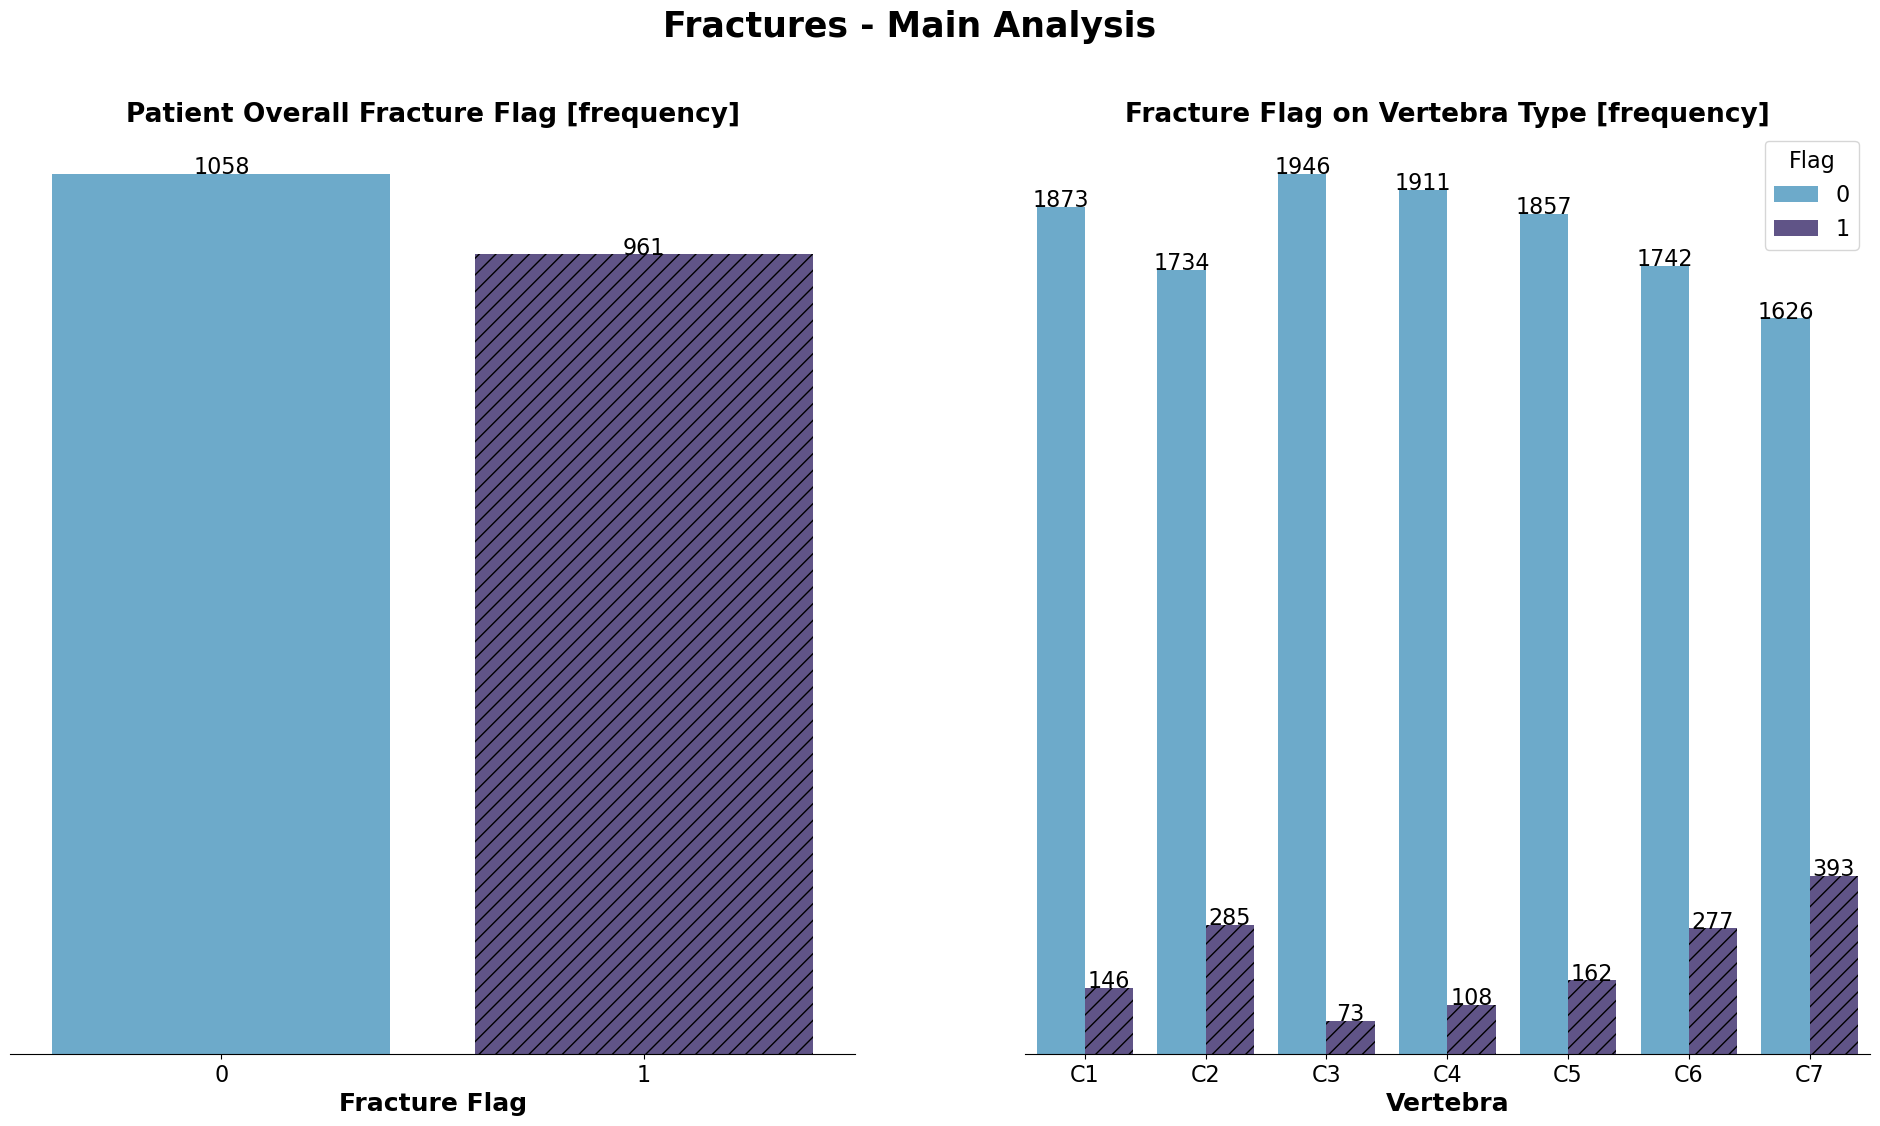

In [27]:
dt = pd.melt(train,
             id_vars=['StudyInstanceUID', 'patient_overall'],
             var_name="Vertebra",
             value_name="Flag")

def show_values_on_bars(ax, h_v="v", space=0.4):
    for p in ax.patches:
        if h_v == "v":
            x = p.get_x() + p.get_width() / 2
            y = p.get_y() + p.get_height()
            value = int(p.get_height())
            ax.text(x, y, value, ha="center")
        else:
            x = p.get_x() + p.get_width() + float(space)
            y = p.get_y() + p.get_height() / 2
            value = int(p.get_width())
            ax.text(x, y, value, ha="left")

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
fig.suptitle('Fractures - Main Analysis',
             weight="bold", size=25)

sns.countplot(data=train, x="patient_overall", ax=ax1, palette=[my_colors[0], my_colors[4]])
show_values_on_bars(ax1, h_v="v", space=0.4)
ax1.set_title("Patient Overall Fracture Flag [frequency]", weight="bold", size=19)
ax1.set_xlabel("Fracture Flag", size = 18, weight="bold")
ax1.set_ylabel("")
ax1.set_yticks([])

hatches = itertools.cycle(['', '//'])
for i, bar in enumerate(ax1.patches):
    hatch = next(hatches)
    bar.set_hatch(hatch)
sns.countplot(data=dt, x="Vertebra", hue="Flag", ax=ax2, palette=[my_colors[0], my_colors[4]])
show_values_on_bars(ax2, h_v="v", space=0.4)
ax2.set_title("Fracture Flag on Vertebra Type [frequency]", weight="bold", size=19)
ax2.set_xlabel("Vertebra", size = 18, weight="bold")
ax2.set_ylabel("")
ax2.set_yticks([])

for i, bar in enumerate(ax2.patches):
    hatch = ''
    if i in [7, 8, 9, 10, 11, 12, 13]:
        hatch = '//'
    bar.set_hatch(hatch)

sns.despine(right=True, top=True, left=True)

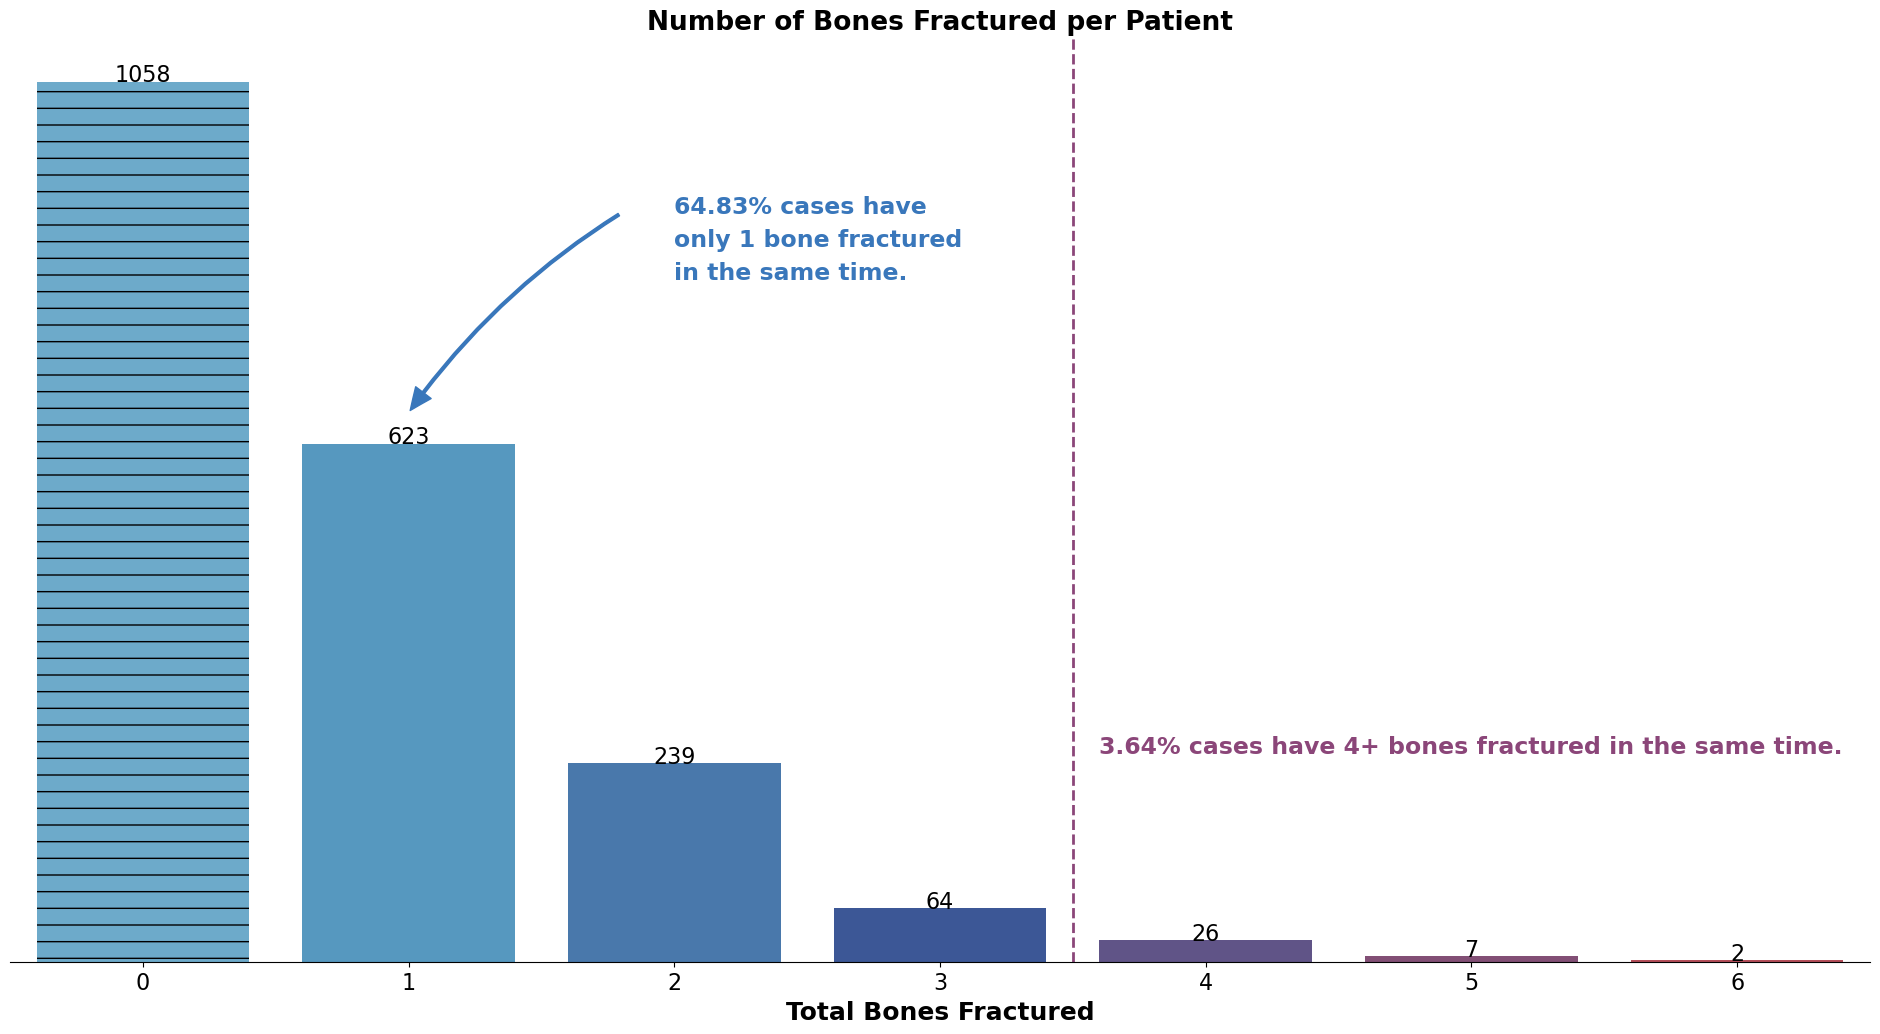

In [29]:
#II. Number of Injuries / Patient
#🦴 Main Takeaways:

#injuries in 1 bone - out of the 961 cases with at least 1 fracture, more than half have an injury in only 1 bone
#injuries in multiple bones - very few cases have injuries in 4 bones or more in the same time
train["total_fractures"] = train.iloc[:, 2:].sum(axis=1)

# Plot
plt.figure(figsize=(24, 12))
axs = sns.countplot(data=train, x="total_fractures", palette=my_colors)
show_values_on_bars(axs, h_v="v", space=0.4)
plt.title("Number of Bones Fractured per Patient", weight="bold", size=19)
plt.xlabel("Total Bones Fractured", size = 18, weight="bold")
plt.ylabel("")
plt.yticks([])

# Hatch
for i, bar in enumerate(axs.patches):
    hatch = ''
    if i==0:
        hatch = '-'
    bar.set_hatch(hatch)
# Arrow
style = "Simple, tail_width=2, head_width=14, head_length=16"
kw = dict(arrowstyle=style, color=my_colors[2])
arrow = patches.FancyArrowPatch((1.8, 900), (1, 660),
                             connectionstyle="arc3,rad=.10", **kw)
plt.gca().add_patch(arrow)
plt.text(x=2, y=900, s=f"{round(623/961*100,2)}% cases have",
         color=my_colors[2], size=17, weight="bold")
plt.text(x=2, y=860, s=f"only 1 bone fractured",
         color=my_colors[2], size=17, weight="bold")
plt.text(x=2, y=820, s=f"in the same time.",
         color=my_colors[2], size=17, weight="bold")
# Line
plt.axvline(x=3.5, linestyle = '--', color=my_colors[5], lw=2)
plt.text(x=3.6, y=250, s=f"{round(35/961*100,2)}% cases have 4+ bones fractured in the same time.",
         color=my_colors[5], size=17, weight="bold")

sns.despine(right=True, top=True, left=True)

Image Data [.dcm]
2.1 Images Understanding 🦴 Steps: Let's first look at a few examples to understand how these images look. Afterwards, we can further extract some details from the .dcm datasets and explore general features (like image size, number of slices per patient etc.).

In [35]:
def natural_keys(text):
    # Define a regular expression pattern to extract numeric substrings
    pattern = re.compile(r'(\d+)')
    # Split the input text into non-numeric and numeric parts
    parts = pattern.split(text)
    # Convert numeric parts to integers for proper comparison
    numeric_parts = [int(part) if part.isdigit() else part for part in parts]
    return numeric_parts

def show_dcm_images(patient_id, rows=4, cols=8, random=0):
    '''Show .dcm images based on id.'''

    N = rows*cols
    wandb_logs = []

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24,15))
    fig.suptitle(f'ID: {patient_id}', weight="bold", size=20)

    # Get .dcm paths
    dcm_paths = glob(f"{BASE}/train_images/{patient_id}/*")
    print(dcm_paths)
    print(clr.S+"Number of TOTAL Slices:"+clr.E, len(dcm_paths))
    dcm_paths.sort(key=natural_keys)
    dcm_paths = dcm_paths[random:(random+N)]
    # Get corresponging datasets and images
    datasets = [pydicom.dcmread(path) for path in dcm_paths]
    images = [apply_voi_lut(dataset.pixel_array, dataset) for dataset in datasets]

    # Loop through the information
    for data, img, i in zip(datasets, images, range(N)):
        slice_no = data.SOPInstanceUID.split(".")[-1]

        # Plot the image
        x = i // cols
        y = i % cols

        axes[x, y].imshow(img, cmap="bone")
        axes[x, y].set_title(f"Slice: {slice_no}",
                  fontsize=14, weight='bold')
        axes[x, y].axis('off')

[]
Number of TOTAL Slices: 0


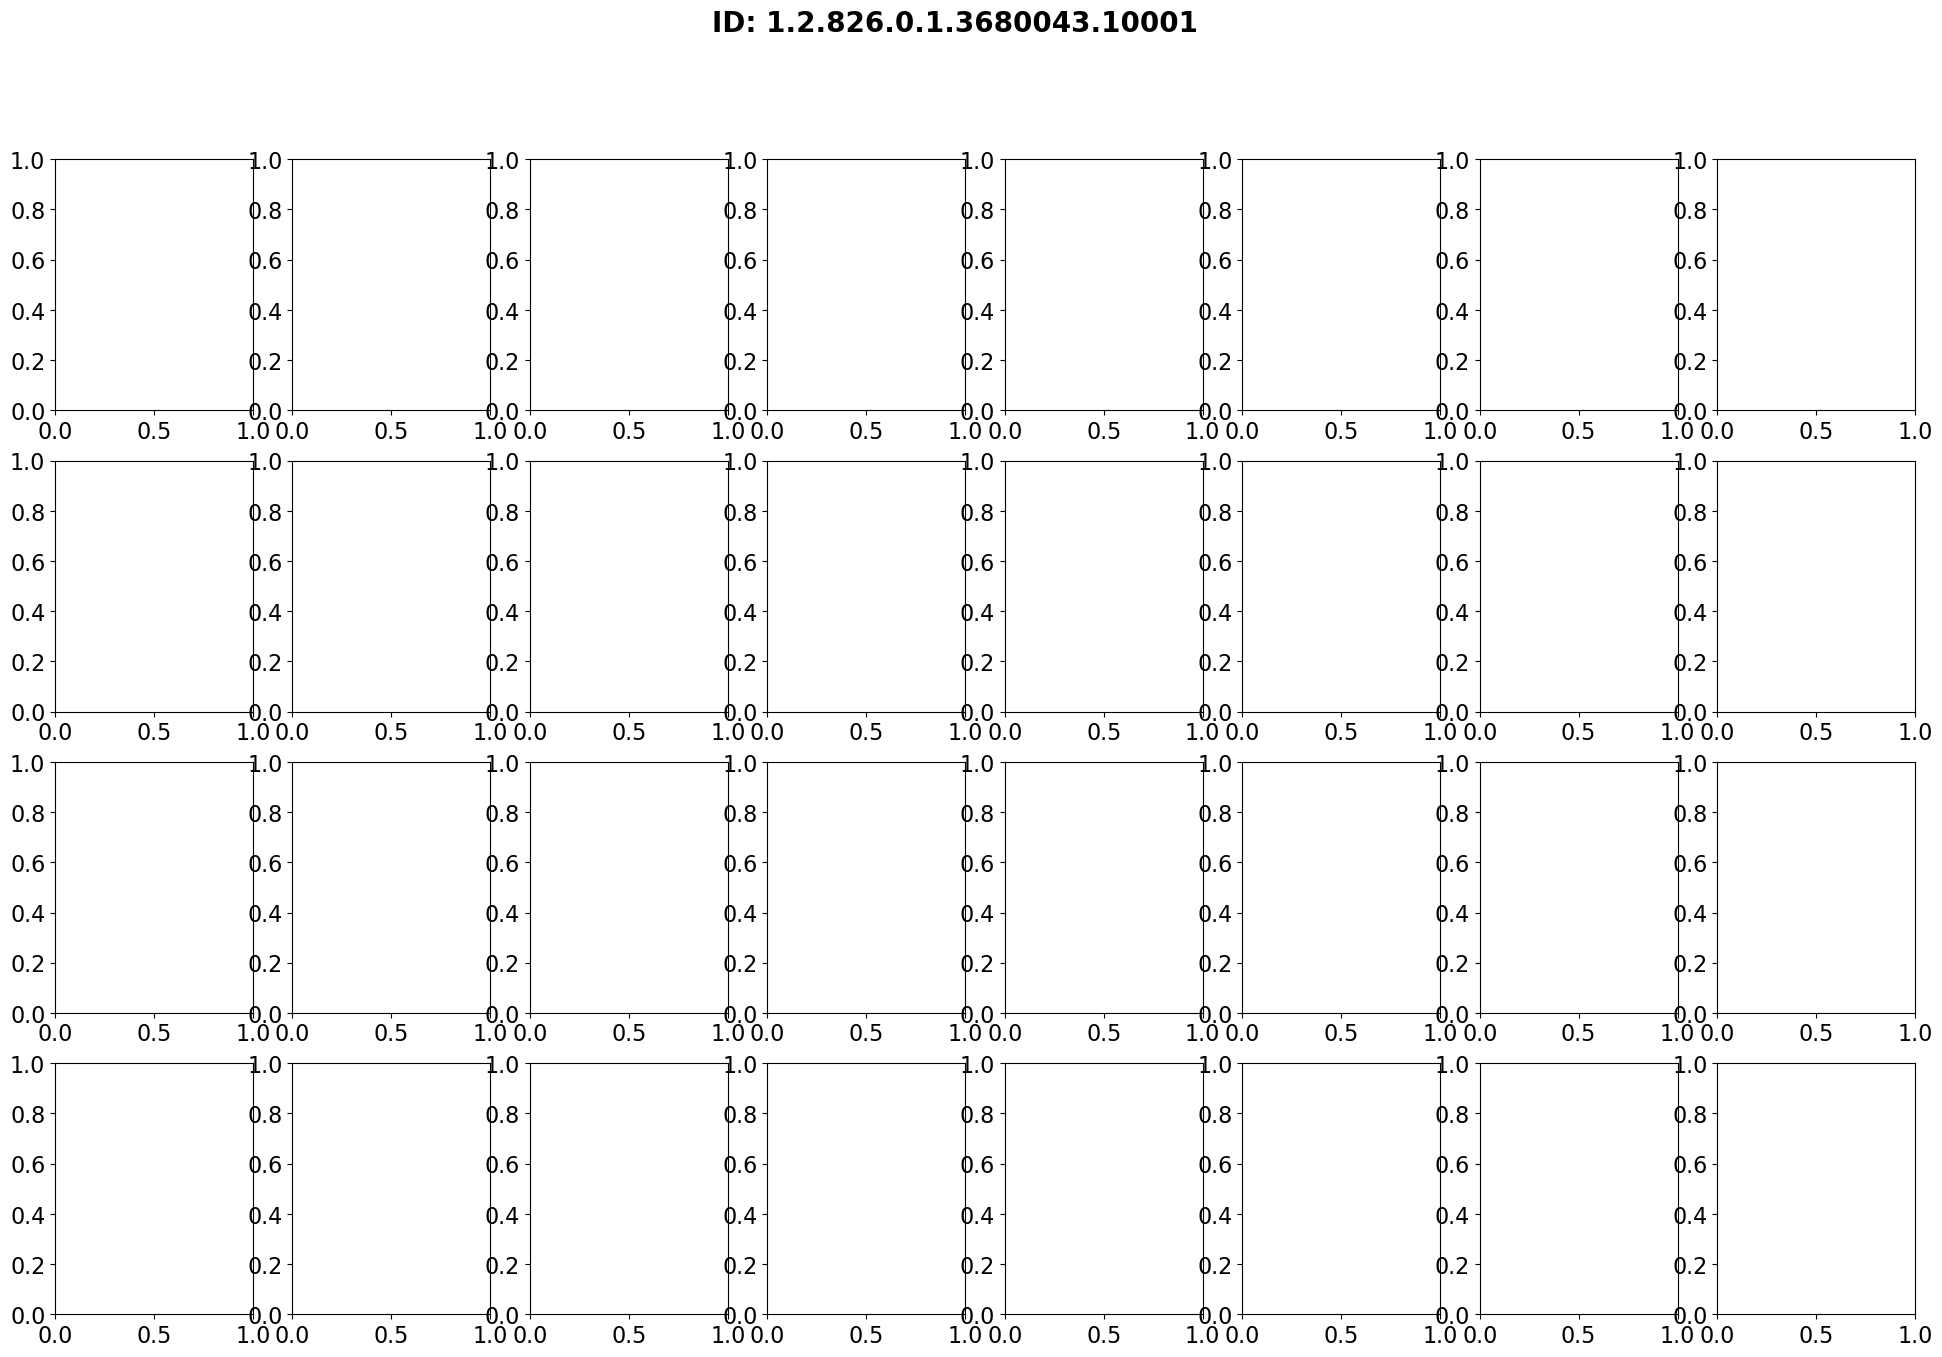

In [36]:
show_dcm_images("1.2.826.0.1.3680043.10001",
                rows=4, cols=8)

2.2 Saving the images The get_images() function reads all the .dcm files for each Study Instance and saves the corresponding images as .png files.

🦴 File Saving: Each saved file is named as follows: StudyInstanceUID/InstanceNumber.png

e.g.: 1.2.826.0.1.3680043.53/4.png StudyInstanceUID -> 1.2.826.0.1.3680043.53 InstanceNumber -> 4 (slice number) in .png format ! Update: I've made a mistake and kept only the images that contain a bbox and excluded all the .dcm files that didn't have any fractures - I've rectified this mistake in V11 of this notebook.

In [30]:
def get_images():
    '''
    Retrieves and saves all .dcm images into a zip file.
    '''

    for k in tqdm(range(len(train))):

        dt = train.iloc[k, :]
        os.mkdir("../working/png_images/" + str(dt.StudyInstanceUID))

        # Get all .dcm paths for this Instance
        dcm_paths = glob(f"{BASE}/train_images/{dt.StudyInstanceUID}/*")

        for path in dcm_paths:
            # Get datasets
            dataset = pydicom.dcmread(path)

            # Get images
            image = apply_voi_lut(dataset.pixel_array, dataset)
            cv2.imwrite(f"../working/png_images/{dataset.StudyInstanceUID}/{dataset.InstanceNumber}.png", image)

    print("PNG Images Saved.")

In [ ]:
# # === Uncomment cell to run ===

# # Create file to store the images
# ! rm -rf png_images
# ! mkdir png_images

# # Save images
# get_images()

# # Zip the png folder and remove original
# zip_name = './zip_png_images/'
# directory_name = './png_images/'

# shutil.make_archive(zip_name, 'zip', directory_name)
# ! rm -rf png_images

In [31]:
total_files = len(glob("../input/rsna-fracture-detection/zip_png_images/*"))
print(clr.S+"Total .png files downloaded and saved:"+clr.E, total_files)

Total .png files downloaded and saved: 0


3. DICOM Metadata
3.1 Retrieving Metadata for 1 file
🦴 At the moment, the only information I would like to retrieve is the following:

Rows -> the height of the CT scan/image
Columns -> the width of the CT scan/image
SOPInstanceUID -> Unique identifier containing the StudyInstanceUID + slice number
ContentDate -> the date the image pixel data creation started
SliceThickness -> gives the thickness of the imaged slice (TODO: maybe pair with Spacing Between Slices - gives the distance between two adjacent slices)
InstanceNumber -> slice number
ImagePositionPatient -> the x, y, and z coordinates of the upper left hand corner (center of the first voxel transmitted) of the image, in mm
ImageOrientationPatient -> the direction cosines of the first row and the first column with respect to the patient
🦴 Note: all attribute explanations are here.

In [32]:
def get_observation_data(path):
    '''
    Get information from the .dcm files
    '''

    dataset = pydicom.read_file(path)

    # Dictionary to store the information from the image
    observation_data = {
        "Rows" : dataset.get("Rows"),
        "Columns" : dataset.get("Columns"),
        "SOPInstanceUID" : dataset.get("SOPInstanceUID"),
        "ContentDate" : dataset.get("ContentDate"),
        "SliceThickness" : dataset.get("SliceThickness"),
        "InstanceNumber" : dataset.get("InstanceNumber"),
        "ImagePositionPatient" : dataset.get("ImagePositionPatient"),
        "ImageOrientationPatient" : dataset.get("ImageOrientationPatient"),
    }
    # String columns
    str_columns = ["SOPInstanceUID", "ContentDate",
                   "SliceThickness", "InstanceNumber"]
    for k in str_columns:
        observation_data[k] = str(dataset.get(k)) if k in dataset else None


    return observation_data

In [ ]:
# An example
path = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10001/109.dcm"
example = get_observation_data(path)
pprint(example)

3.2 Create Metadata file

In [33]:
def get_metadata():
    '''
    Retrieves the desired metadata from the .dcm files and saves it into dataframe.
    '''

    exceptions = 0
    dicts = []

    for k in tqdm(range(len(train))):
        dt = train.iloc[k, :]

        if dt.patient_overall == 1:
            # Get all .dcm paths for this Instance
            dcm_paths = glob(f"{BASE}/train_images/{dt.StudyInstanceUID}/*")

            for path in dcm_paths:
                try:
                    # Get datasets
                    dataset = get_observation_data(path)
                    dicts.append(dataset)
                except Exception as e:
                    exceptions += 1
                    continue

    # Convert into df
    meta_train_data = pd.DataFrame(data=dicts, columns=example.keys())
    # Export information
    meta_train_data.to_csv("meta_train.csv", index=False)

    print(f"Metadata created. Number of total fails: {exceptions}.")

In [ ]:
# Create and save the metadata
# This cell takes ~ 1 hour to run
# get_metadata()

3.3 Metadata Explore¶ Let's play a bit with the data we have just created 

In [ ]:
# Read in saved metadata
meta_train = pd.read_csv("../input/rsna-fracture-detection/meta_train.csv")
meta_train["StudyInstanceUID"] = meta_train["SOPInstanceUID"].apply(lambda x: ".".join(x.split(".")[:-2]))

# Information
print(clr.S+"Total number of .dcm files: (CT scans)"+clr.E, len(meta_train))
print(clr.S+"[sanity check] Total Number of Study Instances"+clr.E, meta_train["StudyInstanceUID"].nunique())

I. Distribution of .dcm files on Study Instance 🦴 To Note:

The distribution is skewed to the right 78% of all observations 200 to 400 slices Only 6% of study instances have less than 200 slices There are 50 Study Instances with more than 600 slices

In [ ]:
# Get the data
data = meta_train["StudyInstanceUID"].value_counts().reset_index()
data.columns = ["StudyInstanceUID", "count"]

In [ ]:
# Plot 1
plt.figure(figsize=(24, 12))
sns.distplot(data["count"], rug=True, bins=10,
             rug_kws={"color": my_colors[1]},
             kde_kws={"color": my_colors[8], "lw": 5, "alpha": 0.7},
             hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": my_colors[1]}
            )

plt.title("Distribution of .dcm files on Study Instance", weight="bold", size=25)
plt.xlabel("Number of Slices", size = 18, weight="bold")
plt.ylabel("Frequency")

# Arrow
style = "Simple, tail_width=1, head_width=12, head_length=14"
kw = dict(arrowstyle=style, color="black")
arrow = patches.FancyArrowPatch((600, 0.0033), (300, 0.0020),
                             connectionstyle="arc3,rad=-.10", **kw)
plt.gca().add_patch(arrow)

plt.text(x=400, y=0.0035, s=f"78% of observations have 200 to 400 slices.",
         color="black", size=17)

sns.despine(right=True, top=True, left=True)

In [ ]:
random.seed(25)

# Add a fictive y
# this "y" doesn't mean anything, it's just for
# showcasing purposes
data["y"] = [random.randint(0, 100) for i in range(len(data))]
perc = round(data[data["count"]<=10].shape[0]/len(data), 3)*100

plt.figure(figsize=(24, 12))
sns.scatterplot(data=data, x="count", y="y", size="count", alpha=0.65, sizes=(500, 2000),
               hue="count", palette=CMAP1)

plt.title("Distribution of .dcm files on Study Instance", weight="bold", size=25)
plt.xlabel("Number of Slices", size = 18, weight="bold")
plt.ylabel("")
plt.yticks([])

plt.axvline(x=200, linestyle = '--', color="black", lw=4)
plt.axvline(x=400, linestyle = '--', color="black", lw=4)
plt.text(x=225, y=50, s=f"~80% of data is here", color="black", size=20, weight="bold")

plt.axvline(x=600, linestyle = '--', color="black", lw=4)
plt.text(x=610, y=7, s=f"only 50 instances with slices >=600", color="black", size=14, weight="bold")
plt.arrow(x=600, y=5, dx=200, dy=0, color="black", lw=4,
          head_width=2, head_length=8)
plt.legend('',frameon=False)
sns.despine(right=True, top=True, left=True)

II. Image sizes 🦴 Note:

99.6% of images have a fixed size of 512 by 512. The rest of the slices (the other 0.3%) should be resized to 512x512 as well.

In [ ]:
# Create column with full image size (height x width)
meta_train["ImageSize"] = meta_train["Rows"].astype(str) + " x " + meta_train["Columns"].astype(str)


# Plot
plt.figure(figsize=(24, 10))
axs = sns.countplot(data=meta_train, x="ImageSize", palette=my_colors[5:])
show_values_on_bars(axs, h_v="v", space=0.4)
plt.title("Frequency of Image Sizes in .dcm data", weight="bold", size=19)
plt.xlabel("Image Size (height x width)", size = 18, weight="bold")
plt.ylabel("")
plt.yticks([])

# Hatch
for i, bar in enumerate(axs.patches):
    hatch = ''
    if i==0:
        hatch = '/'
    bar.set_hatch(hatch)

# Arrow
style = "Simple, tail_width=2, head_width=14, head_length=16"
kw = dict(arrowstyle=style, color=my_colors[4])
arrow = patches.FancyArrowPatch((0.8, 300000), (0.2, 200000),
                             connectionstyle="arc3,rad=.10", **kw)
plt.gca().add_patch(arrow)
plt.text(x=0.8, y=300000, s=f"99.6% of images have size 512x512",
         color=my_colors[4], size=17, weight="bold")

plt.text(x=1, y=70000, s=f"The rest 0.32% should be resized too as 512x512",
         color=my_colors[6], size=17, weight="bold")
plt.axhline(xmin=0.4, xmax=0.95, y=60000, linestyle = '--', color=my_colors[6], lw=2)

sns.despine(right=True, top=True, left=True)

III. Content Date 🦴 Note: All .dcm files have the same creation date (2022-07-27), so this column will be dropped.

In [ ]:
print(clr.S+"The *only* ContentDate is:"+clr.E, meta_train["ContentDate"].value_counts().index)

meta_train.drop(columns="ContentDate", axis=1, inplace=True)
print(clr.S+"Column ContentDate was dropped."+clr.E)

4.Bounding Boxes Let's now analyse only the slices/images with bounding boxes in them (aka the slices that contain 1 or more ruptures.
4.1 Number of Bounding Boxes per Study Instance 🦴 Note:

~50% of all slices have about 25 or less bboxes per study. ! ~16% of slices have less than 10 bboxes per study instance. there are 6 studies that are outliers - with more than 100 bboxes per study. ! Keep in mind: number of bboxes == number of fractures.

In [ ]:
# Plot 1
plt.figure(figsize=(24, 12))
sns.distplot(train_bbox["StudyInstanceUID"].value_counts().values, rug=True, bins=20,
             rug_kws={"color": my_colors[1]},
             kde_kws={"color": my_colors[8], "lw": 5, "alpha": 0.7},
             hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": my_colors[1]}
            )

plt.title("Number of Bounding Boxes per Study Instance", weight="bold", size=25)
plt.xlabel("Number of BBoxes / Study Instance", size = 18, weight="bold")
plt.ylabel("Frequency")

# Arrow
style = "Simple, tail_width=1, head_width=12, head_length=14"
kw = dict(arrowstyle=style, color="black")
arrow = patches.FancyArrowPatch((70, 0.022), (20, 0.018),
                             connectionstyle="arc3,rad=.10", **kw)
plt.gca().add_patch(arrow)
plt.text(x=70, y=0.022, s=f"~50% of slices have less than 25 bboxes/study.",
         color="black", size=17)

style = "Simple, tail_width=1, head_width=12, head_length=14"
kw = dict(arrowstyle=style, color="black")
arrow = patches.FancyArrowPatch((160, 0.008), (150, 0.001),
                             connectionstyle="arc3,rad=.10", **kw)
plt.gca().add_patch(arrow)
plt.text(x=130, y=0.0085, s=f"Only 6 slices have 100+ bboxes/study.",
         color="black", size=17)

sns.despine(right=True, top=True, left=True)

4.2 BBoxes on Images Let's now plot some bounding boxes on out CT scans.

In [ ]:
# Compute x2 and y2
train_bbox["x2"] = train_bbox["x"] + train_bbox["width"]
train_bbox["y2"] = train_bbox["y"] + train_bbox["height"]

# Rename columns
train_bbox.rename(columns={"x": "x1", "y": "y1"}, inplace=True)

# Change to int
train_bbox["x1"] = train_bbox["x1"].apply(lambda x: int(x))
train_bbox["x2"] = train_bbox["x2"].apply(lambda x: int(x))
train_bbox["y1"] = train_bbox["y1"].apply(lambda x: int(x))
train_bbox["y2"] = train_bbox["y2"].apply(lambda x: int(x))

train_bbox.head(3)

In [ ]:
def show_dcm_bboxes(studyInstanceUID, rows, cols):

    # Set defaults
    BASE_PATH = "../input/rsna-2022-cervical-spine-fracture-detection/train_images"
    N = rows*cols

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24,25))

    # Get dataframe & .dcm paths
    bbox_df = train_bbox[train_bbox["StudyInstanceUID"]==studyInstanceUID].reset_index(drop=True).head(N)
    png_paths = [f"{BASE_PATH}/{studyInstanceUID}/{slice_no}.dcm"
                 for slice_no in bbox_df["slice_number"]]

    for path, k in zip(png_paths, range(N)):
        dataset = pydicom.dcmread(path)
        img = apply_voi_lut(dataset.pixel_array, dataset)
        slice_no = png_paths[k].split("/")[-1].split(".")[0]

        # BBoxes
        bbox_list = (bbox_df.loc[k, "x1"], bbox_df.loc[k, "y1"],
                     bbox_df.loc[k, "x2"], bbox_df.loc[k, "y2"])
        x1, y1, x2, y2 = [ int(x) for x in bbox_list ]

        # Plot the image
        x_plot = k // cols
        y_plot = k % cols

        cv2.rectangle(img, (x1, y1), (x2, y2), (226, 56, 54), 5)
        axes[x_plot, y_plot].imshow(img, cmap="bone")
        axes[x_plot, y_plot].set_title(f"Slice: {slice_no}",
                                       fontsize=14, weight='bold')
        axes[x_plot, y_plot].axis('off')

In [ ]:
#Example
show_dcm_bboxes(studyInstanceUID="1.2.826.0.1.3680043.5783",
                rows=6, cols=6)

In [ ]:
#Example
show_dcm_bboxes(studyInstanceUID="1.2.826.0.1.3680043.19778",
                rows=6, cols=6)

In [ ]:
#Example
show_dcm_bboxes(studyInstanceUID="1.2.826.0.1.3680043.31077",
                rows=6, cols=6)

3D CT Scans 🙏 This part is completely inspired by Seungwon Song's notebook: Break Time☕️ Just Enjoy drawing 3D cervical spine which I LOVED so I had to create something similar and learn ♥
🦴 nifti file format -> NIfTI (.nii) is a type of file format for neuroimaging.

In [ ]:
class DrawMaskSample():

    def __init__(self, nii_paths, i, ax):
        self.i = i
        self.ax = ax
        self.nii_sample = nib.load(nii_paths[self.i]).get_fdata()
        self.get_xyz()
        self.draw_sample_3d()

    def get_xyz(self):
        self.xyz_li = []
        cnt = 0
        max_cnt = self.nii_sample.shape[-1]
        for iter_z, (iter_img) in enumerate(self.nii_sample.transpose(2,0,1)):
            for iter_x, iter_arr_y in enumerate(iter_img):
                iter_arr_y = np.where(iter_arr_y)[0]
                if len(iter_arr_y) >= 1:
                    iter_arr_y = list(set([iter_arr_y.max(), iter_arr_y.min()]))
                    xyz = [(iter_x, iter_y, iter_z) for iter_y in iter_arr_y if np.any(iter_y)]

In [ ]:
fig = plt.figure(figsize=(24,24))
for i in range(9):
    ax = fig.add_subplot(int(f'33{i+1}'), projection='3d')
    DrawMaskSample(nii_paths, i, ax)

plt.tight_layout()
plt.show()

In [ ]:
# Save datasets
train.to_csv("train.csv", index=False)
meta_train.to_csv("meta_train_clean.csv", index=False)